Get the working environment going.

In [ ]:


import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt; plt.ion()
import os, rasterio
import rasterio.plot
import scipy.spatial as sp
from sklearn.linear_model import LinearRegression
import numpy as np
from scipy import stats
from matplotlib.patches import Patch
from matplotlib_scalebar.scalebar import ScaleBar


In [5]:
spatDir="/home/daniel/Documents/projects/fichtelSoils/fichtelgebirgeSoils/spatialAnalysis"
## ^different on laptop
os.chdir(spatDir)

Get sulari's data:

In [8]:
## on officeComp
sulariEnvCSV="/home/daniel/Documents/projects/fichtelSoils/fichtelgebirgeSoils/sulariData/Envt_Matrix.csv"
## on laptop
#sulariEnvCSV="/home/daniel/Documents/projects/fichtelgebirge_project/sulariArneSoils/fichtelgebirgeSoils/sulariData/Envt_Matrix.csv"
envData = pd.read_csv(sulariEnvCSV, index_col=0)

## clean it up a bit
## we need to clean up the plot.ID. Sulari recorded season in the plot IDs,
## using letter codes. Also she has one double sampling, with an underscore

envData['Plot.ID'] = envData['Plot.ID'].str.slice(0,5)
## drop controls
envData.drop([ "C1.1", "C1.2", "C2.1", "C2.2"], inplace=True)

envData.head()

,Plot.ID,Date,soil.respiration,srpuc,MBC,season,Land.type,pH,N,C,CNR,Temperature,Moisture,Latitude,Longitude
Sample ID,,,,,,,,,,,,,,,
S1,P0104,04/07/2022,1.892454,74.653008,0.961063,S,Arableland,6.919,0.213,2.535,11.901408,18.9,15.797262,50.105065,11.922489
S2,P0156,06/07/2022,6.558051,115.703091,1.458421,S,Grassland,5.828,0.435,5.668,13.029885,16.9,9.509603,50.073714,11.954150
S3,P0204,05/07/2022,2.141342,59.880935,0.468984,S,Forest,4.214,0.134,3.576,26.686567,12.9,19.264706,50.055621,11.952927
S4,P0105,25/07/2022,2.030831,107.224446,0.568533,S,Arableland,5.520,0.164,1.894,11.548780,17.2,4.192597,50.176334,11.840065
S5,P0155,14/07/2022,6.476892,83.218455,2.279664,S,Grassland,7.051,0.685,7.783,11.362044,17.6,11.037206,50.129343,11.808350


The following is the code for generating Sulari's ASV-level community matrix from her phyloseq object, in R. (can skip)

In [ ]:
##### R ###
library('phyloseq')
load("/home/daniel/Documents/projects/fichtelSoils/fichtelgebirgeSoils/sulariData/sularilogMin50ps.rda")
logMin50ps
comdat <- as.data.frame(otu_table(logMin50ps))
write.csv(comdat, file="/home/daniel/Documents/projects/fichtelSoils/fichtelgebirgeSoils/sulariData/comdat.csv")
############


In [9]:
comData = pd.read_csv("/home/daniel/Documents/projects/fichtelSoils/fichtelgebirgeSoils/sulariData/comdat.csv", index_col=0)

comData.drop([ "C1.1", "C1.2", "C2.1", "C2.2"], inplace=True)

comData.head()


,ASV1,ASV2,ASV3,ASV4,ASV5,ASV6,ASV7,ASV8,ASV9,ASV10,...,ASV36131,ASV36132,ASV36133,ASV36134,ASV36135,ASV36136,ASV36137,ASV36138,ASV36139,ASV36140
S1,0.000000,0.032530,0.016008,0.010700,0.011428,0.008738,0.006490,0.003053,0.020011,0.005984,...,0,0,0,0,0,0,0,0,0,0
S2,0.000000,0.006536,0.023847,0.010878,0.029067,0.005589,0.001848,0.000000,0.001740,0.001821,...,0,0,0,0,0,0,0,0,0,0
S3,0.006919,0.001895,0.003264,0.043099,0.001210,0.017189,0.042306,0.017963,0.001069,0.028395,...,0,0,0,0,0,0,0,0,0,0
S4,0.011532,0.020729,0.014881,0.014121,0.004279,0.005844,0.000000,0.001880,0.001911,0.000000,...,0,0,0,0,0,0,0,0,0,0
S5,0.000000,0.009767,0.019855,0.004334,0.018471,0.003210,0.000000,0.000000,0.027292,0.000000,...,0,0,0,0,0,0,0,0,0,0


Make a spatial dataframe...

In [12]:
plotPoints = gpd.points_from_xy( envData.Longitude, envData.Latitude, crs="EPSG:4326" )

sulariPlotsDF = gpd.GeoDataFrame(envData[[ 'Plot.ID', 'soil.respiration',
                    'MBC', 'season', 'Land.type', 'pH', 'N', 'C']], geometry=plotPoints)

## to convert to UTM? looks like we are in zone 33
## looks like:
## EPSG:32633

sulariPlot_utm = sulariPlotsDF.to_crs('EPSG:32633')

sulariPlot_utm.tail()

,Plot.ID,soil.respiration,MBC,season,Land.type,pH,N,C,geometry
Sample ID,,,,,,,,,
S116,P0203,1.022541,0.452289,SP,Forest,4.348,0.073,1.730,POINT (274684.681 5558574.847)
S117,P0209,1.650842,0.488906,SP,Forest,3.847,0.128,2.559,POINT (282466.942 5565510.521)
S118,P0105,1.468438,0.799233,SP,Arableland,5.703,0.165,1.790,POINT (274386.567 5563017.017)
S119,P0204,3.054180,0.473599,SP,Forest,3.791,0.157,4.586,POINT (281895.213 5549263.192)
S120,P0213,1.067608,0.406645,SP,Forest,4.043,0.110,2.410,POINT (272613.867 5567969.743)


And let's make some maps!

In [13]:
fichtelMap = rasterio.open("studyAreaClipped_UTM.tif")

## color code our points according to land type?
cdik={
"Arableland":"b",
"Grassland":"y",
"Forest":"g",
}
sulariPlotsDF['landColors'] = [ cdik[i] for i in sulariPlotsDF['Land.type'] ]
sulariPlot_utm['landColors'] = [ cdik[i] for i in sulariPlotsDF['Land.type'] ]


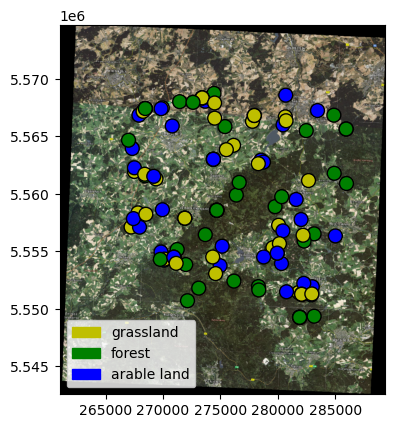

In [17]:
fig, ax = plt.subplots()
rasterio.plot.show(fichtelMap, ax=ax)
sulariPlot_utm.plot(
    marker="o",
    ax=ax,
    edgecolor='k',
    facecolor=sulariPlotsDF['landColors'],
    markersize=100)

grassPatch = Patch(color='y', label='grassland',)
forestPatch = Patch(color='g', label='forest')
farmPatch = Patch(color='b', label='arable land')
ax.legend(handles=[grassPatch, forestPatch, farmPatch],
          loc="lower left",
          fontsize=10,
)

